# NB06: Robustness Checks & NMDC Trait Validation

**Goal**: Address analytical gaps identified in the project review:
1. **H1b Formal Test** — statistically test whether stress-condition dark genes are more likely accessory than carbon/nitrogen dark genes
2. **Dark-vs-Annotated Concordance Control** — test whether dark gene cross-organism concordance patterns differ from annotated genes (H0 rejection)
3. **NMDC Trait-Condition Concordance** — test whether dark gene carrier genera are enriched in NMDC samples with matching community functional traits

**Requires**: BERDL JupyterHub (Spark access for specog and NMDC queries)

**Inputs**: `data/dark_genes_integrated.tsv` (NB01), `data/concordance_scores.tsv` (NB02)

**Outputs**: `data/h1b_test_results.tsv`, `data/annotated_control_concordance.tsv`, `data/nmdc_trait_validation.tsv`, `figures/fig16_h1b_test.png`, `figures/fig17_concordance_comparison.png`, `figures/fig21_trait_correlations.png`

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import fisher_exact, chi2_contingency, mannwhitneyu, ks_2samp
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Spark session
spark = get_spark_session()

# Project paths
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_DIR = os.path.dirname(os.getcwd())
else:
    PROJECT_DIR = os.getcwd()

DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')
os.makedirs(FIG_DIR, exist_ok=True)

print(f'Project dir: {PROJECT_DIR}')

Project dir: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter


In [2]:
# Load NB01 unified table
unified = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_integrated.tsv'), sep='\t', low_memory=False)
unified['locusId'] = unified['locusId'].astype(str)
dark = unified[unified['is_dark'] == True].copy()
annotated = unified[unified['is_dark'] == False].copy()

# Load NB02 concordance scores for dark OGs
dark_concordance = pd.read_csv(os.path.join(DATA_DIR, 'concordance_scores.tsv'), sep='\t')

print(f'Unified table: {len(unified):,} genes')
print(f'  Dark: {len(dark):,}')
print(f'  Annotated: {len(annotated):,}')
print(f'Dark concordance OGs: {len(dark_concordance)}')

Unified table: 228,709 genes
  Dark: 57,011
  Annotated: 171,698
Dark concordance OGs: 65


## Section 1: H1b Formal Test

**Hypothesis H1b**: Dark genes important under stress conditions are more likely to be accessory (environment-specific) than dark genes important for carbon/nitrogen metabolism (which should be more core).

**Test**: Fisher's exact test on 2x2 contingency table: (stress vs carbon/nitrogen) × (core vs accessory)

In [3]:
# Filter to dark genes with both condition class and core/accessory info
h1b_data = dark[
    dark['top_condition_class'].notna() &
    (dark['is_core'].notna() | dark['is_auxiliary'].notna())
].copy()

# Classify conservation status
h1b_data['conservation'] = 'other'
h1b_data.loc[h1b_data['is_core'] == True, 'conservation'] = 'core'
h1b_data.loc[h1b_data['is_auxiliary'] == True, 'conservation'] = 'accessory'
h1b_data = h1b_data[h1b_data['conservation'].isin(['core', 'accessory'])]

# Classify condition groups
h1b_data['condition_group'] = 'other'
h1b_data.loc[h1b_data['top_condition_class'] == 'stress', 'condition_group'] = 'stress'
h1b_data.loc[h1b_data['top_condition_class'].isin(['carbon source', 'nitrogen source']), 'condition_group'] = 'carbon_nitrogen'
h1b_data = h1b_data[h1b_data['condition_group'].isin(['stress', 'carbon_nitrogen'])]

print(f'Dark genes testable for H1b: {len(h1b_data):,}')
print(f'\nCondition x Conservation crosstab:')
ct = pd.crosstab(h1b_data['condition_group'], h1b_data['conservation'])
print(ct)
print(f'\nWith row percentages:')
ct_pct = pd.crosstab(h1b_data['condition_group'], h1b_data['conservation'], normalize='index') * 100
print(ct_pct.round(1))

Dark genes testable for H1b: 7,491

Condition x Conservation crosstab:
conservation     accessory  core
condition_group                 
carbon_nitrogen        702  2050
stress                1088  3651

With row percentages:
conservation     accessory  core
condition_group                 
carbon_nitrogen       25.5  74.5
stress                23.0  77.0


In [4]:
# Build 2x2 contingency table
#                     Core    Accessory
# Stress              a       b
# Carbon/Nitrogen     c       d

a = int(ct.loc['stress', 'core'])
b = int(ct.loc['stress', 'accessory'])
c = int(ct.loc['carbon_nitrogen', 'core'])
d = int(ct.loc['carbon_nitrogen', 'accessory'])

table_2x2 = [[a, b], [c, d]]

# Fisher's exact test
odds_ratio_fisher, p_fisher = fisher_exact(table_2x2)

# Chi-squared test
chi2, p_chi2, dof, expected = chi2_contingency(table_2x2)

print('H1b Formal Test Results')
print('=' * 50)
print(f'\nContingency table:')
print(f'                    Core    Accessory    Total    % Accessory')
print(f'  Stress:          {a:>5d}      {b:>5d}     {a+b:>5d}       {100*b/(a+b):.1f}%')
print(f'  Carbon/Nitrogen: {c:>5d}      {d:>5d}     {c+d:>5d}       {100*d/(c+d):.1f}%')
print(f'\nH1b prediction: stress genes should have HIGHER % accessory')
print(f'Observed: stress = {100*b/(a+b):.1f}% accessory, carbon/nitrogen = {100*d/(c+d):.1f}% accessory')
if b/(a+b) > d/(c+d):
    print(f'Direction: CONSISTENT with H1b (stress more accessory)')
else:
    print(f'Direction: OPPOSITE to H1b (carbon/nitrogen more accessory)')
print(f'\nFisher\'s exact test:')
print(f'  Odds ratio: {odds_ratio_fisher:.3f}')
print(f'  p-value: {p_fisher:.4f}')
print(f'\nChi-squared test:')
print(f'  Chi2: {chi2:.2f}, dof: {dof}, p-value: {p_chi2:.4f}')
print(f'\nConclusion:', end=' ')
if p_fisher < 0.05:
    print(f'SIGNIFICANT at p < 0.05')
else:
    print(f'NOT significant at p < 0.05')

H1b Formal Test Results

Contingency table:
                    Core    Accessory    Total    % Accessory
  Stress:           3651       1088      4739       23.0%
  Carbon/Nitrogen:  2050        702      2752       25.5%

H1b prediction: stress genes should have HIGHER % accessory
Observed: stress = 23.0% accessory, carbon/nitrogen = 25.5% accessory
Direction: OPPOSITE to H1b (carbon/nitrogen more accessory)

Fisher's exact test:
  Odds ratio: 1.149
  p-value: 0.0134

Chi-squared test:
  Chi2: 6.09, dof: 1, p-value: 0.0136

Conclusion: SIGNIFICANT at p < 0.05


In [5]:
# Extended analysis: test all condition classes, not just stress vs carbon/nitrogen
h1b_all = dark[
    dark['top_condition_class'].notna() &
    (dark['is_core'] == True) | (dark['is_auxiliary'] == True)
].copy()
h1b_all['conservation'] = 'other'
h1b_all.loc[h1b_all['is_core'] == True, 'conservation'] = 'core'
h1b_all.loc[h1b_all['is_auxiliary'] == True, 'conservation'] = 'accessory'
h1b_all = h1b_all[h1b_all['conservation'].isin(['core', 'accessory'])]

# Per-condition accessory fraction
cond_conservation = h1b_all.groupby('top_condition_class').agg(
    n_total=('locusId', 'count'),
    n_core=('is_core', 'sum'),
    n_accessory=('is_auxiliary', 'sum'),
).reset_index()
cond_conservation['pct_accessory'] = 100 * cond_conservation['n_accessory'] / cond_conservation['n_total']
cond_conservation = cond_conservation.sort_values('pct_accessory', ascending=False)

print('Accessory fraction by condition class:')
print(cond_conservation.to_string(index=False))

Accessory fraction by condition class:
             top_condition_class  n_total n_core n_accessory pct_accessory
                       alp richb        1  False        True         100.0
                   sulfur source        1  False        True         100.0
                     rich moyls4        1  False        True         100.0
                metal limitation        6      1           5     83.333333
supernatant control:fungal media        6      1           5     83.333333
    r2a control with 0.2x vogels        3      1           2     66.666667
     varel_bryant_medium_glucose        5      2           3          60.0
                         control       50     22          28          56.0
                     r2a control       13      6           7     53.846154
                           mouse       43     20          23     53.488372
                              lb       82     45          37     45.121951
                           plant      101     57          44 

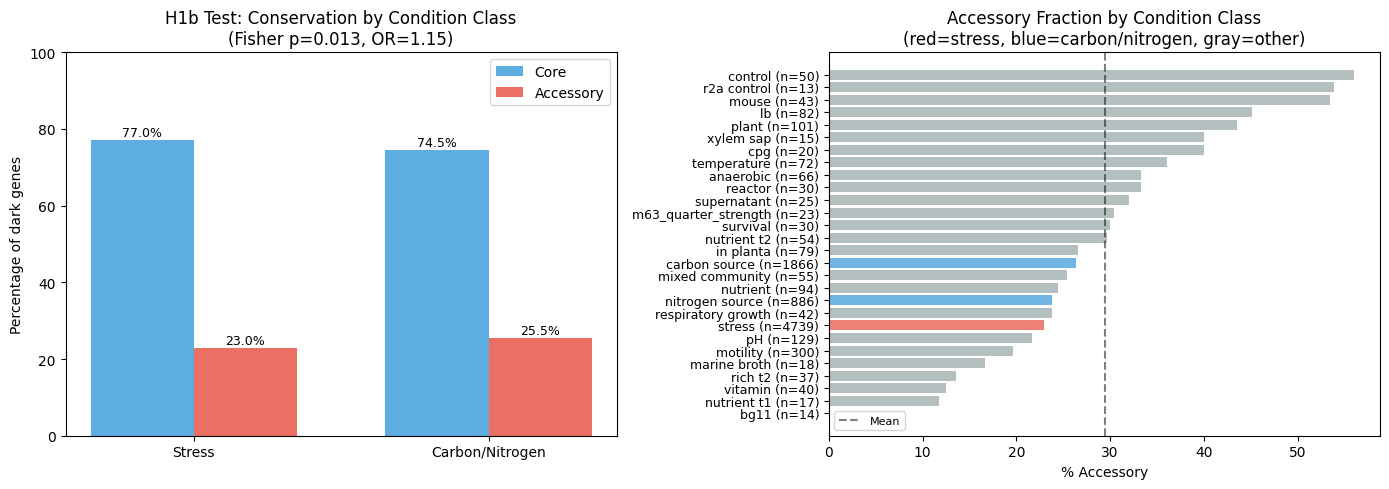

Saved fig16_h1b_test.png


In [6]:
# Figure 16: H1b test visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Grouped bar chart for stress vs carbon/nitrogen
ax = axes[0]
groups = ['Stress', 'Carbon/Nitrogen']
core_pcts = [100*a/(a+b), 100*c/(c+d)]
acc_pcts = [100*b/(a+b), 100*d/(c+d)]
x = np.arange(len(groups))
width = 0.35
bars1 = ax.bar(x - width/2, core_pcts, width, label='Core', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, acc_pcts, width, label='Accessory', color='#e74c3c', alpha=0.8)
ax.set_ylabel('Percentage of dark genes')
ax.set_title(f'H1b Test: Conservation by Condition Class\n(Fisher p={p_fisher:.3f}, OR={odds_ratio_fisher:.2f})')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend()
ax.set_ylim(0, 100)
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{bar.get_height():.1f}%', ha='center', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{bar.get_height():.1f}%', ha='center', fontsize=9)

# Panel B: All condition classes
ax = axes[1]
cc = cond_conservation[cond_conservation['n_total'] >= 10].copy()  # Only classes with N>=10
cc = cc.sort_values('pct_accessory')
y_pos = range(len(cc))
colors = ['#e74c3c' if c == 'stress' else '#3498db' if c in ('carbon source', 'nitrogen source') else '#95a5a6'
          for c in cc['top_condition_class']]
ax.barh(y_pos, cc['pct_accessory'].values, color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels([f"{c} (n={n})" for c, n in zip(cc['top_condition_class'], cc['n_total'])], fontsize=9)
ax.set_xlabel('% Accessory')
ax.set_title('Accessory Fraction by Condition Class\n(red=stress, blue=carbon/nitrogen, gray=other)')
ax.axvline(x=cc['pct_accessory'].mean(), color='black', linestyle='--', alpha=0.5, label='Mean')
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig16_h1b_test.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig16_h1b_test.png')

In [7]:
# Save H1b test results
h1b_results = pd.DataFrame({
    'test': ['H1b_core_accessory'],
    'stress_core': [a],
    'stress_accessory': [b],
    'carbon_nitrogen_core': [c],
    'carbon_nitrogen_accessory': [d],
    'stress_pct_accessory': [100*b/(a+b)],
    'carbon_nitrogen_pct_accessory': [100*d/(c+d)],
    'fisher_odds_ratio': [odds_ratio_fisher],
    'fisher_p_value': [p_fisher],
    'chi2_statistic': [chi2],
    'chi2_p_value': [p_chi2],
    'direction_consistent_with_h1b': [b/(a+b) > d/(c+d)],
})
h1b_results.to_csv(os.path.join(DATA_DIR, 'h1b_test_results.tsv'), sep='\t', index=False)
print('Saved h1b_test_results.tsv')

Saved h1b_test_results.tsv


## Section 2: Dark-vs-Annotated Concordance Control

**Goal**: Test whether dark gene cross-organism concordance is a special property of dark genes, or whether annotated genes show similar patterns. If annotated genes also show high concordance (as expected — known functions should produce consistent phenotypes), then dark gene concordance is evidence that they behave like real functional genes, supporting H1.

**Approach**: Query `specog` for a matched sample of annotated-gene ortholog groups, compute concordance identically to NB02, and compare distributions.

In [8]:
# Identify annotated-gene OGs with 3+ FB organisms
# First, find OGs that contain ONLY annotated genes in FB
# (Using the specog ogId, which we need to look up via the specog table itself)

# Get the set of dark gene (orgId, locusId) pairs
dark_set = set(zip(dark['orgId'], dark['locusId'].astype(str)))

# Query specog to find all OGs and their members
# First get all unique ogIds and their member counts
all_specog_summary = spark.sql("""
    SELECT ogId,
           COUNT(DISTINCT orgId) as n_organisms,
           COUNT(DISTINCT CONCAT(orgId, ':', locusId)) as n_members
    FROM kescience_fitnessbrowser.specog
    GROUP BY ogId
    HAVING COUNT(DISTINCT orgId) >= 3
""").toPandas()

print(f'Total specog OGs with 3+ organisms: {len(all_specog_summary):,}')
print(f'Dark OG concordance scores: {len(dark_concordance)} OGs')

# The dark OGs are already known (from NB02)
dark_og_ids = set(dark_concordance['ogId'].astype(str))

# Candidate annotated OGs = all 3+ organism OGs minus dark OGs
annot_candidate_ogs = all_specog_summary[
    ~all_specog_summary['ogId'].astype(str).isin(dark_og_ids)
].copy()
print(f'Candidate annotated OGs (3+ organisms, not dark): {len(annot_candidate_ogs):,}')

Total specog OGs with 3+ organisms: 750
Dark OG concordance scores: 65 OGs
Candidate annotated OGs (3+ organisms, not dark): 685


In [9]:
# Stratified sampling: match the organism-count distribution of the 65 dark OGs
dark_org_dist = dark_concordance['total_organisms'].value_counts().sort_index()
print('Dark OG organism-count distribution:')
print(dark_org_dist)

# For each organism count bin, sample proportionally (scaled up to ~500 total)
np.random.seed(42)
scale_factor = min(500 / len(dark_concordance), len(annot_candidate_ogs) / len(dark_concordance))
scale_factor = min(scale_factor, 8)  # Cap at 8x

sampled_annot_ogs = []
for n_orgs, count in dark_org_dist.items():
    target_n = max(int(count * scale_factor), count)  # At least match dark count
    pool = annot_candidate_ogs[annot_candidate_ogs['n_organisms'] == n_orgs]
    if len(pool) == 0:
        # Try nearest bin
        pool = annot_candidate_ogs[
            (annot_candidate_ogs['n_organisms'] >= n_orgs - 1) &
            (annot_candidate_ogs['n_organisms'] <= n_orgs + 1)
        ]
    sample_n = min(target_n, len(pool))
    if sample_n > 0:
        sampled = pool.sample(n=sample_n, random_state=42)
        sampled_annot_ogs.append(sampled)

sampled_annot = pd.concat(sampled_annot_ogs, ignore_index=True)
print(f'\nSampled annotated OGs: {len(sampled_annot)}')
print(f'Organism-count distribution of sample:')
print(sampled_annot['n_organisms'].value_counts().sort_index())

Dark OG organism-count distribution:
total_organisms
3     35
4     16
5      3
6      3
7      3
8      3
10     2
Name: count, dtype: int64

Sampled annotated OGs: 490
Organism-count distribution of sample:
n_organisms
3     269
4     123
5      23
6      23
7      23
8      23
10      6
Name: count, dtype: int64


In [10]:
# Query specog for sampled annotated OGs (identical pattern to NB02 cell-11)
annot_og_ids = sampled_annot['ogId'].tolist()
og_spark = spark.createDataFrame([(str(og),) for og in annot_og_ids], ['ogId'])
og_spark.createOrReplaceTempView('target_annot_ogs')

annot_specog = spark.sql("""
    SELECT s.ogId, s.expGroup, s.condition, s.orgId, s.locusId,
           CAST(s.minFit AS FLOAT) as minFit,
           CAST(s.maxFit AS FLOAT) as maxFit,
           CAST(s.minT AS FLOAT) as minT,
           CAST(s.maxT AS FLOAT) as maxT,
           CAST(s.nInOG AS INT) as nInOG
    FROM kescience_fitnessbrowser.specog s
    JOIN target_annot_ogs t ON s.ogId = t.ogId
""").toPandas()

print(f'Annotated specog entries: {len(annot_specog):,}')
print(f'OGs represented: {annot_specog["ogId"].nunique()}')

Annotated specog entries: 1,962
OGs represented: 490


In [11]:
# Compute concordance for annotated OGs (identical method to NB02 cell-12/13)
# FIX: n_strong must count unique organisms with strong effects, not sum of boolean rows
# (an organism can have multiple conditions per expGroup, inflating n_strong > n_organisms)

# Strong effect thresholds (same as NB02)
annot_specog['has_strong_effect'] = (annot_specog['minFit'].abs() > 1) & (annot_specog['minT'].abs() > 3)

# Per OG x expGroup: count organisms with strong effects
# Use nunique on organisms that have strong effects to avoid double-counting
annot_strong = annot_specog[annot_specog['has_strong_effect']].copy()
n_strong_per_group = annot_strong.groupby(['ogId', 'expGroup'])['orgId'].nunique().reset_index()
n_strong_per_group.columns = ['ogId', 'expGroup', 'n_strong_unique']

annot_concordance_raw = annot_specog.groupby(['ogId', 'expGroup']).agg(
    n_organisms=('orgId', 'nunique'),
    n_strong_sum=('has_strong_effect', 'sum'),  # Old method (can exceed n_organisms)
    min_of_minFit=('minFit', 'min'),
    mean_minFit=('minFit', 'mean'),
).reset_index()

# Merge corrected n_strong (unique organisms with strong effects)
annot_concordance_raw = annot_concordance_raw.merge(
    n_strong_per_group, on=['ogId', 'expGroup'], how='left'
)
annot_concordance_raw['n_strong_unique'] = annot_concordance_raw['n_strong_unique'].fillna(0).astype(int)

# Use corrected concordance (guaranteed <= 1.0)
annot_concordance_raw['concordance_frac'] = annot_concordance_raw['n_strong_unique'] / annot_concordance_raw['n_organisms']

# Verify fix
assert annot_concordance_raw['concordance_frac'].max() <= 1.0, \
    f"BUG: concordance_frac max = {annot_concordance_raw['concordance_frac'].max()}"

# Show how many were affected by the old bug
n_affected = (annot_concordance_raw['n_strong_sum'] > annot_concordance_raw['n_organisms']).sum()
print(f'Concordance rows where old method exceeded 1.0: {n_affected}')
print(f'Concordance_frac range: [{annot_concordance_raw["concordance_frac"].min():.3f}, '
      f'{annot_concordance_raw["concordance_frac"].max():.3f}]')

# Per-OG summary: max concordance across condition classes
annot_og_concordance = annot_concordance_raw.sort_values('concordance_frac', ascending=False).groupby('ogId').agg(
    best_condition=('expGroup', 'first'),
    max_concordance=('concordance_frac', 'max'),
    n_condition_classes=('expGroup', 'nunique'),
    total_organisms=('n_organisms', 'max'),
).reset_index()

print(f'\nAnnotated OG concordance summary: {len(annot_og_concordance)} OGs')
print(f'\nAnnotated concordance distribution (FIXED):')
print(annot_og_concordance['max_concordance'].describe())
print(f'\nDark concordance distribution (from NB02):')
print(dark_concordance['max_concordance'].describe())

Concordance rows where old method exceeded 1.0: 4
Concordance_frac range: [0.333, 1.000]

Annotated OG concordance summary: 490 OGs

Annotated concordance distribution (FIXED):
count    490.000000
mean       0.983941
std        0.082277
min        0.333333
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: max_concordance, dtype: float64

Dark concordance distribution (from NB02):
count    65.000000
mean      0.976007
std       0.089940
min       0.500000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: max_concordance, dtype: float64


In [12]:
# Statistical comparison: dark vs annotated concordance
dark_scores = dark_concordance['max_concordance'].values
annot_scores = annot_og_concordance['max_concordance'].values

# Mann-Whitney U test
stat_mw, p_mw = mannwhitneyu(dark_scores, annot_scores, alternative='two-sided')

# KS test
stat_ks, p_ks = ks_2samp(dark_scores, annot_scores)

print('Dark vs. Annotated Concordance Comparison')
print('=' * 50)
print(f'\nDark OGs:      n={len(dark_scores)}, median={np.median(dark_scores):.3f}, mean={np.mean(dark_scores):.3f}')
print(f'Annotated OGs: n={len(annot_scores)}, median={np.median(annot_scores):.3f}, mean={np.mean(annot_scores):.3f}')
print(f'\nMann-Whitney U test:')
print(f'  U statistic: {stat_mw:.1f}')
print(f'  p-value: {p_mw:.4e}')
print(f'\nKolmogorov-Smirnov test:')
print(f'  KS statistic: {stat_ks:.3f}')
print(f'  p-value: {p_ks:.4e}')
print(f'\nInterpretation:', end=' ')
if p_mw < 0.05:
    if np.median(dark_scores) > np.median(annot_scores):
        print('Dark genes show HIGHER concordance than annotated genes.')
        print('This is unexpected and may reflect selection bias (only OGs with 3+ organisms tested).')
    else:
        print('Annotated genes show HIGHER concordance than dark genes.')
        print('Dark gene concordance is real but weaker than annotated genes, consistent with partial/noisy function.')
else:
    print('No significant difference in concordance between dark and annotated genes.')
    print('Dark genes show comparable concordance to annotated genes — supporting H1 (they behave like real functional genes).')

Dark vs. Annotated Concordance Comparison

Dark OGs:      n=65, median=1.000, mean=0.976
Annotated OGs: n=490, median=1.000, mean=0.984

Mann-Whitney U test:
  U statistic: 15395.0
  p-value: 2.3384e-01

Kolmogorov-Smirnov test:
  KS statistic: 0.034
  p-value: 1.0000e+00

Interpretation: No significant difference in concordance between dark and annotated genes.
Dark genes show comparable concordance to annotated genes — supporting H1 (they behave like real functional genes).


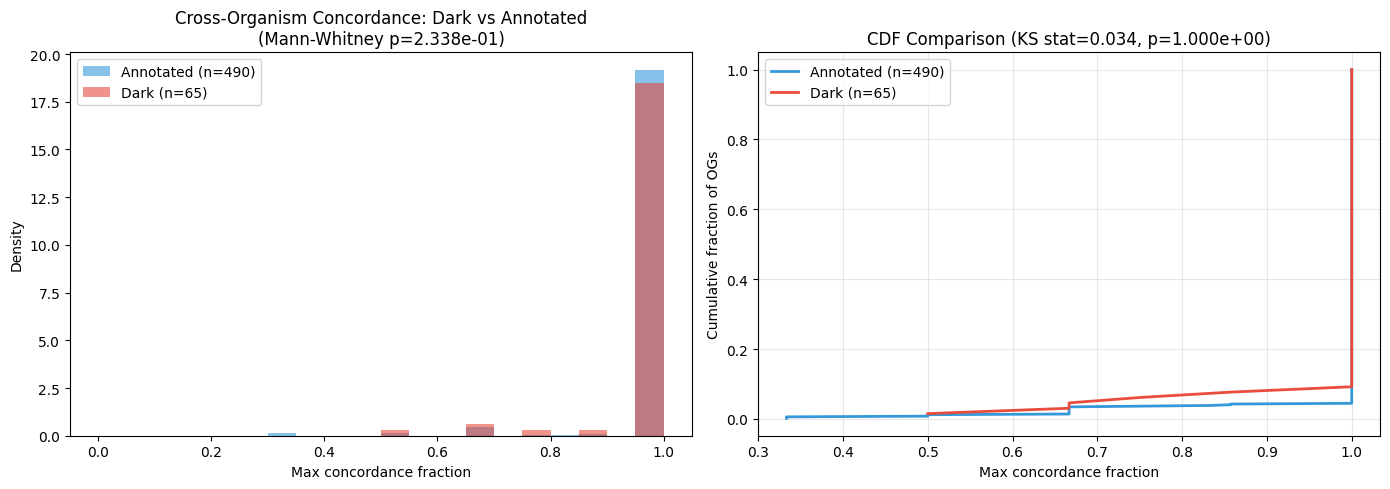

Saved fig17_concordance_comparison.png


In [13]:
# Figure 17: Concordance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Side-by-side histograms
ax = axes[0]
bins = np.linspace(0, 1, 21)
ax.hist(annot_scores, bins=bins, alpha=0.6, color='#3498db', label=f'Annotated (n={len(annot_scores)})', density=True)
ax.hist(dark_scores, bins=bins, alpha=0.6, color='#e74c3c', label=f'Dark (n={len(dark_scores)})', density=True)
ax.set_xlabel('Max concordance fraction')
ax.set_ylabel('Density')
ax.set_title(f'Cross-Organism Concordance: Dark vs Annotated\n(Mann-Whitney p={p_mw:.3e})')
ax.legend()

# Panel B: CDF comparison
ax = axes[1]
for scores, label, color in [
    (annot_scores, f'Annotated (n={len(annot_scores)})', '#3498db'),
    (dark_scores, f'Dark (n={len(dark_scores)})', '#e74c3c')
]:
    sorted_scores = np.sort(scores)
    cdf = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
    ax.plot(sorted_scores, cdf, label=label, color=color, linewidth=2)
ax.set_xlabel('Max concordance fraction')
ax.set_ylabel('Cumulative fraction of OGs')
ax.set_title(f'CDF Comparison (KS stat={stat_ks:.3f}, p={p_ks:.3e})')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig17_concordance_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig17_concordance_comparison.png')

In [14]:
# Save annotated concordance control data
annot_og_concordance.to_csv(os.path.join(DATA_DIR, 'annotated_control_concordance.tsv'), sep='\t', index=False)
print(f'Saved annotated_control_concordance.tsv ({len(annot_og_concordance)} OGs)')

Saved annotated_control_concordance.tsv (490 OGs)


## Section 3: NMDC Trait-Condition Concordance

**Goal**: Test whether NMDC samples with high community-level functional trait scores (e.g., nitrogen fixation) also have high abundance of dark gene carrier genera whose lab phenotypes match that trait.

**Pre-registered predictions** (defined before analysis):

| FB Condition | NMDC Trait Column | Expected Direction |
|---|---|---|
| nitrogen source | `functional_group:nitrogen_fixation` | Positive |
| nitrogen source | `functional_group:nitrate_denitrification` | Positive |
| carbon source | `functional_group:aerobic_chemoheterotrophy` | Positive |
| carbon source | `functional_group:fermentation` | Positive |
| anaerobic | `functional_group:fermentation` | Positive |
| anaerobic | `functional_group:iron_respiration` | Positive |
| stress | `functional_group:iron_respiration` | Positive |

**Method**: Same genus-level taxonomy bridge as NB04 (two-tier ncbi_taxid mapping). Spearman correlation between carrier genus abundance and matching trait scores, FDR-BH corrected.

In [15]:
# Step 1: Load NMDC trait_features and taxonomy_features
traits = spark.sql("SELECT * FROM nmdc_arkin.trait_features").toPandas()
taxonomy = spark.sql("SELECT * FROM nmdc_arkin.taxonomy_features").toPandas()
taxonomy_dim = spark.sql("SELECT * FROM nmdc_arkin.taxonomy_dim").toPandas()

# Identify functional_group columns
func_group_cols = [c for c in traits.columns if c.startswith('functional_group:')]
print(f'Trait features: {traits.shape[0]} samples x {traits.shape[1]} columns')
print(f'Functional group columns: {len(func_group_cols)}')
print(f'Taxonomy features: {taxonomy.shape[0]} samples x {taxonomy.shape[1]} columns')
print(f'Taxonomy dim: {len(taxonomy_dim)} entries')

# Show first few functional group columns with sample values
print(f'\nSample functional group values (first sample):')
for col in func_group_cols[:10]:
    val = traits[col].iloc[0] if len(traits) > 0 else 'N/A'
    print(f'  {col}: {val}')

Trait features: 6365 samples x 92 columns
Functional group columns: 76
Taxonomy features: 6365 samples x 3493 columns
Taxonomy dim: 2594787 entries

Sample functional group values (first sample):
  functional_group:aerobic_chemoheterotrophy: 0.4797079854270886
  functional_group:fermentation: 0.11009247214834544
  functional_group:nitrate_denitrification: 0.9161186013131078
  functional_group:nitrate_respiration: 0.2010580388949314
  functional_group:nitrogen_fixation: 1.250205848780634
  functional_group:dark_thiosulfate_oxidation: 0.6972798928243794
  functional_group:nitrate_reduction: -0.2778353814531425
  functional_group:aromatic_compound_degradation: 0.02723817788494637
  functional_group:aromatic_hydrocarbon_degradation: -0.024688930073488644
  functional_group:arsenite_oxidation_energy_yielding: 0.8522265114880153


In [16]:
# Step 2: Extract carrier genera from FB organisms by condition class

fb_organisms = spark.sql("""
    SELECT orgId, genus, species, taxonomyId, division
    FROM kescience_fitnessbrowser.organism
""").toPandas()

# Map dark genes to genera by condition class (require strong fitness effect)
dark_cond = dark[dark['top_condition_class'].notna() & (dark['max_abs_fit'] >= 2)].copy()
dark_cond = dark_cond.merge(fb_organisms[['orgId', 'genus']], on='orgId', how='left')

carrier_genera_by_condition = {}
for cond_class in ['stress', 'carbon source', 'nitrogen source', 'anaerobic', 'motility', 'pH']:
    cond_subset = dark_cond[dark_cond['top_condition_class'] == cond_class]
    genera = set(cond_subset['genus'].dropna().unique())
    if genera:
        carrier_genera_by_condition[cond_class] = genera

all_carrier_genera = set()
for g_set in carrier_genera_by_condition.values():
    all_carrier_genera.update(g_set)

print(f'Carrier genera by condition class:')
for cond, genera in sorted(carrier_genera_by_condition.items()):
    print(f'  {cond}: {len(genera)} genera — {", ".join(sorted(genera)[:5])}{"..." if len(genera) > 5 else ""}')
print(f'\nTotal unique carrier genera: {len(all_carrier_genera)}')

Carrier genera by condition class:
  anaerobic: 4 genera — Dechlorosoma, Dinoroseobacter, Pseudomonas, Shewanella
  carbon source: 24 genera — Acidovorax, Azospirillum, Bacteroides, Burkholderia, Caulobacter...
  motility: 8 genera — Acidovorax, Azospirillum, Burkholderia, Escherichia, Kangiella...
  nitrogen source: 21 genera — Acidovorax, Azospirillum, Bacteroides, Burkholderia, Caulobacter...
  pH: 7 genera — Acidovorax, Klebsiella, Marinobacter, Phaeobacter, Pseudomonas...
  stress: 25 genera — Acidovorax, Azospirillum, Bacteroides, Burkholderia, Caulobacter...

Total unique carrier genera: 28


In [17]:
# Step 3: Map NMDC taxon columns to carrier genera via taxonomy_dim
# taxonomy_dim columns: taxid, kingdom, phylum, class, order, family, genus, species
# taxonomy_features columns are taxid values (as strings)

# Get all taxon columns from taxonomy_features
taxon_cols = [c for c in taxonomy.columns if c != 'sample_id']
taxon_col_set = set(taxon_cols)
print(f'Taxon columns in taxonomy_features: {len(taxon_cols)}')

# Map taxid → genus using taxonomy_dim directly
# Filter to entries whose genus matches a carrier genus AND whose taxid is a column
taxon_to_genus = {}
taxon_to_conditions = {}

for _, row in taxonomy_dim.iterrows():
    tid = str(row['taxid'])
    genus = row.get('genus', '')
    
    if pd.isna(genus) or genus == '' or genus == 'Unclassified':
        continue
    if genus not in all_carrier_genera:
        continue
    if tid not in taxon_col_set:
        continue
    
    taxon_to_genus[tid] = genus
    # Map to condition classes
    conditions = [cond for cond, genera in carrier_genera_by_condition.items() 
                  if genus in genera]
    taxon_to_conditions[tid] = conditions

print(f'Taxon columns mapped to carrier genera: {len(taxon_to_genus)}')
print(f'Unique genera matched: {len(set(taxon_to_genus.values()))}')
print(f'Matched genera: {sorted(set(taxon_to_genus.values()))}')

# Show per-genus counts
from collections import Counter
genus_counts = Counter(taxon_to_genus.values())
print(f'\nTaxon columns per genus (top 10):')
for g, n in genus_counts.most_common(10):
    print(f'  {g}: {n} taxon columns')

Taxon columns in taxonomy_features: 3492


Taxon columns mapped to carrier genera: 347
Unique genera matched: 26
Matched genera: ['Acidovorax', 'Azospirillum', 'Bacteroides', 'Burkholderia', 'Caulobacter', 'Cupriavidus', 'Desulfovibrio', 'Dickeya', 'Dinoroseobacter', 'Dyella', 'Echinicola', 'Escherichia', 'Herbaspirillum', 'Kangiella', 'Klebsiella', 'Magnetospirillum', 'Marinobacter', 'Paraburkholderia', 'Pedobacter', 'Phaeobacter', 'Pontibacter', 'Pseudomonas', 'Shewanella', 'Sinorhizobium', 'Sphingomonas', 'Synechococcus']

Taxon columns per genus (top 10):
  Pseudomonas: 129 taxon columns
  Burkholderia: 41 taxon columns
  Shewanella: 20 taxon columns
  Synechococcus: 17 taxon columns
  Paraburkholderia: 15 taxon columns
  Sphingomonas: 14 taxon columns
  Cupriavidus: 10 taxon columns
  Marinobacter: 10 taxon columns
  Bacteroides: 10 taxon columns
  Klebsiella: 8 taxon columns


In [18]:
# Step 4: Compute per-sample carrier genus abundance by condition class
# For each condition class, sum abundance of all taxon columns mapped to carrier genera for that condition

from scipy import stats
from statsmodels.stats.multitest import multipletests

# Merge traits and taxonomy on sample_id
merged = taxonomy.merge(traits, on='sample_id', how='inner')
print(f'Merged samples (taxonomy + traits): {len(merged):,}')

# Compute condition-specific carrier abundance scores
for cond_class in carrier_genera_by_condition:
    matching_taxon_cols = [tid for tid, conds in taxon_to_conditions.items() 
                          if cond_class in conds and tid in merged.columns]
    if matching_taxon_cols:
        merged[f'carrier_{cond_class}'] = merged[matching_taxon_cols].apply(
            pd.to_numeric, errors='coerce'
        ).sum(axis=1)
    else:
        merged[f'carrier_{cond_class}'] = 0
    
    n_nonzero = (merged[f'carrier_{cond_class}'] > 0).sum()
    print(f'  {cond_class}: {len(matching_taxon_cols)} taxon cols, '
          f'{n_nonzero} samples with non-zero carrier abundance')

# Pre-registered trait-condition predictions
PREREGISTERED = [
    ('nitrogen source', 'functional_group:nitrogen_fixation', 'positive'),
    ('nitrogen source', 'functional_group:nitrate_denitrification', 'positive'),
    ('carbon source', 'functional_group:aerobic_chemoheterotrophy', 'positive'),
    ('carbon source', 'functional_group:fermentation', 'positive'),
    ('anaerobic', 'functional_group:fermentation', 'positive'),
    ('anaerobic', 'functional_group:iron_respiration', 'positive'),
    ('stress', 'functional_group:iron_respiration', 'positive'),
]

# Verify pre-registered trait columns exist
for cond, trait_col, direction in PREREGISTERED:
    exists = trait_col in merged.columns
    carrier_col = f'carrier_{cond}'
    has_carrier = carrier_col in merged.columns and merged[carrier_col].sum() > 0
    print(f'  {cond} ~ {trait_col}: trait exists={exists}, carrier data={has_carrier}')

Merged samples (taxonomy + traits): 6,365
  stress: 322 taxon cols, 2304 samples with non-zero carrier abundance
  carbon source: 323 taxon cols, 2418 samples with non-zero carrier abundance
  nitrogen source: 310 taxon cols, 2302 samples with non-zero carrier abundance
  anaerobic: 150 taxon cols, 1063 samples with non-zero carrier abundance
  motility: 225 taxon cols, 2092 samples with non-zero carrier abundance
  pH: 184 taxon cols, 1413 samples with non-zero carrier abundance
  nitrogen source ~ functional_group:nitrogen_fixation: trait exists=True, carrier data=True
  nitrogen source ~ functional_group:nitrate_denitrification: trait exists=True, carrier data=True
  carbon source ~ functional_group:aerobic_chemoheterotrophy: trait exists=True, carrier data=True
  carbon source ~ functional_group:fermentation: trait exists=True, carrier data=True
  anaerobic ~ functional_group:fermentation: trait exists=True, carrier data=False
  anaerobic ~ functional_group:iron_respiration: trait 

/tmp/ipykernel_40934/2154734835.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged[f'carrier_{cond_class}'] = merged[matching_taxon_cols].apply(
/tmp/ipykernel_40934/2154734835.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged[f'carrier_{cond_class}'] = merged[matching_taxon_cols].apply(
/tmp/ipykernel_40934/2154734835.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

In [19]:
# Step 5: Run all trait-condition correlations (pre-registered + exploratory)
MIN_SAMPLES = 30

results = []

# Pre-registered tests
for cond, trait_col, expected_dir in PREREGISTERED:
    carrier_col = f'carrier_{cond}'
    if carrier_col not in merged.columns or trait_col not in merged.columns:
        print(f'  SKIP {cond} ~ {trait_col}: missing columns')
        continue
    
    carrier_vals = pd.to_numeric(merged[carrier_col], errors='coerce')
    trait_vals = pd.to_numeric(merged[trait_col], errors='coerce')
    valid = carrier_vals.notna() & trait_vals.notna() & (carrier_vals > 0)
    
    if valid.sum() >= MIN_SAMPLES:
        rho, p = stats.spearmanr(carrier_vals[valid], trait_vals[valid])
        direction_match = (expected_dir == 'positive' and rho > 0) or \
                         (expected_dir == 'negative' and rho < 0)
        results.append({
            'condition_class': cond,
            'trait_column': trait_col,
            'n_samples': int(valid.sum()),
            'spearman_rho': rho,
            'p_value': p,
            'expected_direction': expected_dir,
            'observed_direction': 'positive' if rho > 0 else 'negative',
            'direction_match': direction_match,
            'test_type': 'pre-registered',
        })
    else:
        print(f'  SKIP {cond} ~ {trait_col}: only {valid.sum()} valid samples (need {MIN_SAMPLES})')

# Exploratory: test all carrier × functional_group combinations
for cond_class in carrier_genera_by_condition:
    carrier_col = f'carrier_{cond_class}'
    if carrier_col not in merged.columns:
        continue
    carrier_vals = pd.to_numeric(merged[carrier_col], errors='coerce')
    
    for trait_col in func_group_cols:
        # Skip pre-registered pairs (already tested above)
        is_prereg = any(cond == cond_class and tc == trait_col 
                       for cond, tc, _ in PREREGISTERED)
        if is_prereg:
            continue
        
        trait_vals = pd.to_numeric(merged[trait_col], errors='coerce')
        valid = carrier_vals.notna() & trait_vals.notna() & (carrier_vals > 0)
        
        if valid.sum() >= MIN_SAMPLES:
            rho, p = stats.spearmanr(carrier_vals[valid], trait_vals[valid])
            results.append({
                'condition_class': cond_class,
                'trait_column': trait_col,
                'n_samples': int(valid.sum()),
                'spearman_rho': rho,
                'p_value': p,
                'expected_direction': '',
                'observed_direction': 'positive' if rho > 0 else 'negative',
                'direction_match': None,
                'test_type': 'exploratory',
            })

# Build results DataFrame
if len(results) > 0:
    trait_results = pd.DataFrame(results)
    print(f'Total trait-condition tests: {len(trait_results)}')
    print(f'  Pre-registered: {(trait_results["test_type"] == "pre-registered").sum()}')
    print(f'  Exploratory: {(trait_results["test_type"] == "exploratory").sum()}')
    
    # FDR correction (separate for pre-registered and exploratory)
    prereg_mask = trait_results['test_type'] == 'pre-registered'
    if prereg_mask.sum() > 0:
        _, fdr_prereg, _, _ = multipletests(
            trait_results.loc[prereg_mask, 'p_value'], method='fdr_bh'
        )
        trait_results.loc[prereg_mask, 'fdr'] = fdr_prereg
    
    expl_mask = trait_results['test_type'] == 'exploratory'
    if expl_mask.sum() > 0:
        _, fdr_expl, _, _ = multipletests(
            trait_results.loc[expl_mask, 'p_value'], method='fdr_bh'
        )
        trait_results.loc[expl_mask, 'fdr'] = fdr_expl
    
    # Report pre-registered results
    print(f'\n--- Pre-registered Predictions ---')
    prereg = trait_results[trait_results['test_type'] == 'pre-registered'].copy()
    if len(prereg) > 0:
        n_confirmed = prereg['direction_match'].sum()
        n_sig = (prereg['fdr'] < 0.05).sum()
        print(f'Tested: {len(prereg)}/{len(PREREGISTERED)}')
        print(f'Direction confirmed: {n_confirmed}/{len(prereg)}')
        print(f'FDR < 0.05: {n_sig}/{len(prereg)}')
        print()
        for _, row in prereg.iterrows():
            sig = '***' if row['fdr'] < 0.001 else '**' if row['fdr'] < 0.01 else '*' if row['fdr'] < 0.05 else 'ns'
            match = 'CONFIRMED' if row['direction_match'] else 'OPPOSITE'
            print(f'  {row["condition_class"]:20s} ~ {row["trait_column"]:45s} '
                  f'rho={row["spearman_rho"]:+.3f} FDR={row["fdr"]:.2e} n={row["n_samples"]:>4d} '
                  f'{match} {sig}')
    
    # Report exploratory highlights
    print(f'\n--- Exploratory (top 10 by significance) ---')
    expl = trait_results[trait_results['test_type'] == 'exploratory'].sort_values('p_value')
    if len(expl) > 0:
        n_sig_expl = (expl['fdr'] < 0.05).sum()
        print(f'Total exploratory tests: {len(expl)}')
        print(f'FDR < 0.05: {n_sig_expl}')
        for _, row in expl.head(10).iterrows():
            sig = '***' if row['fdr'] < 0.001 else '**' if row['fdr'] < 0.01 else '*' if row['fdr'] < 0.05 else 'ns'
            print(f'  {row["condition_class"]:20s} ~ {row["trait_column"]:45s} '
                  f'rho={row["spearman_rho"]:+.3f} FDR={row["fdr"]:.2e} n={row["n_samples"]:>4d} {sig}')
else:
    trait_results = pd.DataFrame()
    print('WARNING: No trait-condition tests could be run')
    print('  Check carrier genus abundance and trait column availability above')

Total trait-condition tests: 456
  Pre-registered: 7
  Exploratory: 449

--- Pre-registered Predictions ---
Tested: 7/7
Direction confirmed: True/7
FDR < 0.05: 7/7

  nitrogen source      ~ functional_group:nitrogen_fixation            rho=+0.599 FDR=4.47e-224 n=2302 CONFIRMED ***
  nitrogen source      ~ functional_group:nitrate_denitrification      rho=+0.677 FDR=8.50e-308 n=2302 CONFIRMED ***
  carbon source        ~ functional_group:aerobic_chemoheterotrophy    rho=+0.730 FDR=0.00e+00 n=2418 CONFIRMED ***
  carbon source        ~ functional_group:fermentation                 rho=+0.508 FDR=1.65e-158 n=2418 CONFIRMED ***
  anaerobic            ~ functional_group:fermentation                 rho=+0.316 FDR=4.53e-26 n=1063 CONFIRMED ***
  anaerobic            ~ functional_group:iron_respiration             rho=+0.286 FDR=2.02e-21 n=1063 CONFIRMED ***
  stress               ~ functional_group:iron_respiration             rho=+0.435 FDR=1.29e-106 n=2304 CONFIRMED ***

--- Exploratory (t

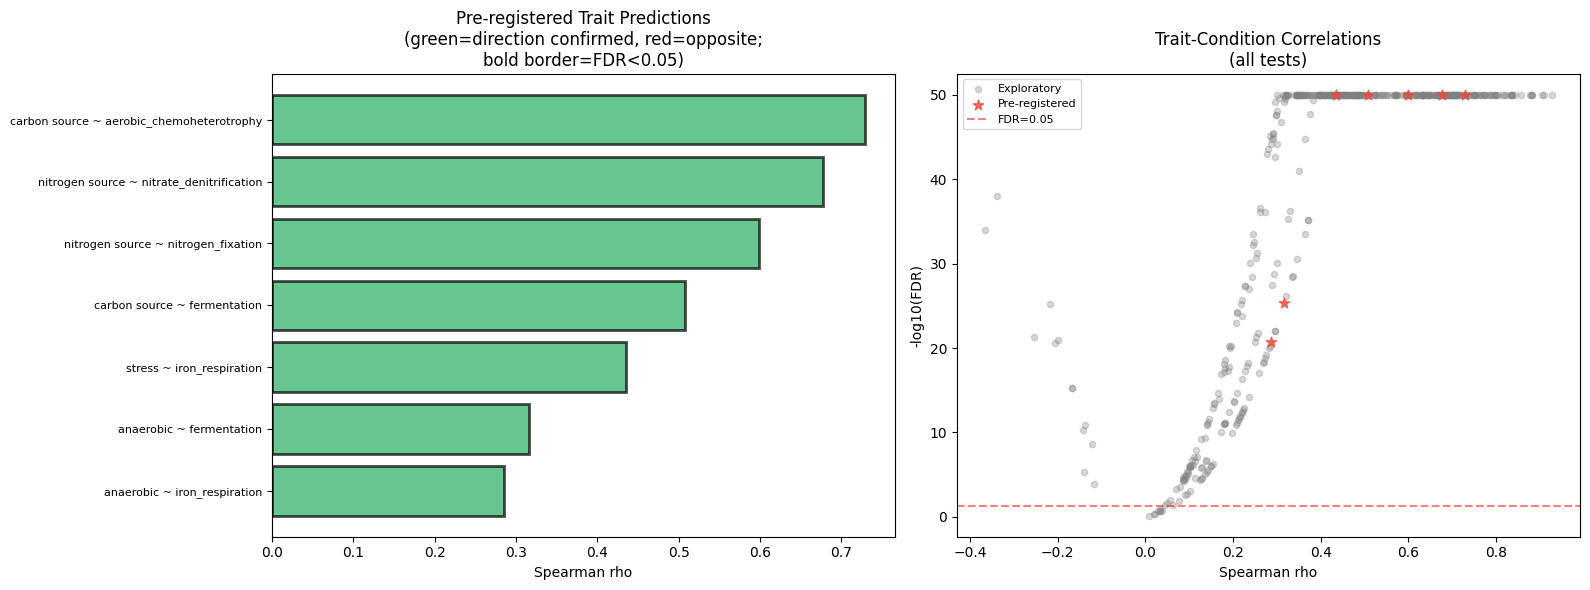

Saved fig21_trait_correlations.png


In [20]:
# Figure 21: Trait-condition correlation results
if len(trait_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Panel A: Pre-registered predictions
    ax = axes[0]
    prereg = trait_results[trait_results['test_type'] == 'pre-registered'].copy()
    if len(prereg) > 0:
        prereg['label'] = prereg['condition_class'] + ' ~ ' + prereg['trait_column'].str.replace('functional_group:', '')
        prereg = prereg.sort_values('spearman_rho')
        colors = ['#27AE60' if m else '#E74C3C' for m in prereg['direction_match']]
        edge_colors = ['black' if f < 0.05 else 'gray' for f in prereg['fdr']]
        ax.barh(range(len(prereg)), prereg['spearman_rho'], color=colors, alpha=0.7,
                edgecolor=edge_colors, linewidth=[2 if f < 0.05 else 0.5 for f in prereg['fdr']])
        ax.set_yticks(range(len(prereg)))
        ax.set_yticklabels(prereg['label'], fontsize=8)
        ax.set_xlabel('Spearman rho')
        ax.set_title('Pre-registered Trait Predictions\n(green=direction confirmed, red=opposite;\nbold border=FDR<0.05)')
        ax.axvline(x=0, color='black', linewidth=0.5)
    else:
        ax.text(0.5, 0.5, 'No pre-registered\ntests run', ha='center', va='center', fontsize=12)
        ax.set_title('Pre-registered Trait Predictions')
    
    # Panel B: Volcano plot of all tests
    ax = axes[1]
    if len(trait_results) > 0:
        trait_results['neg_log10_fdr'] = -np.log10(trait_results['fdr'].clip(lower=1e-50))
        prereg_mask = trait_results['test_type'] == 'pre-registered'
        expl_mask = trait_results['test_type'] == 'exploratory'
        
        ax.scatter(trait_results.loc[expl_mask, 'spearman_rho'],
                  trait_results.loc[expl_mask, 'neg_log10_fdr'],
                  alpha=0.3, s=20, color='gray', label='Exploratory')
        ax.scatter(trait_results.loc[prereg_mask, 'spearman_rho'],
                  trait_results.loc[prereg_mask, 'neg_log10_fdr'],
                  alpha=0.8, s=60, color='#E74C3C', marker='*', label='Pre-registered', zorder=5)
        ax.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.5, label='FDR=0.05')
        ax.set_xlabel('Spearman rho')
        ax.set_ylabel('-log10(FDR)')
        ax.set_title('Trait-Condition Correlations\n(all tests)')
        ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'fig21_trait_correlations.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved fig21_trait_correlations.png')
else:
    print('No trait results to plot')

In [21]:
# Save trait validation results
if len(trait_results) > 0:
    trait_results.to_csv(os.path.join(DATA_DIR, 'nmdc_trait_validation.tsv'), sep='\t', index=False)
    print(f'Saved nmdc_trait_validation.tsv ({len(trait_results)} tests)')
else:
    print('No trait results to save')

Saved nmdc_trait_validation.tsv (456 tests)
